# Week 13 Programming Assignment

The final thing for this semester that we haven't exercised, yet, is working with databases and combining data from multiple different sources.  In this last assignment of the semester before the final project, we'll be combining data from the internet, an existing database, and some local files on our Jupyter server.

**Please be careful to make sure that any code creating database tables has your username in the table name so that they don't conflict with other students.  The database is a shared environment.**

This example works with the hospital price transparency data that we've looked at in class from time to time.  For this work, we're going to compare data from two different facilities after it's been merged with another reference data set.

Follow the instructions below, writing and testing your code using the assert statements.  Then submit your assignment as usual.

## 1. Getting data from a relational database

In our database, there is a table called `fiverivers` that contains price transparency data for the St. Bernhard's Five Rivers hospital location.  Write code to retrieve that data from the database and load it to a Pandas dataframe.

I'll give you the code you need to connect to the database to make the first step easier.

In [1]:
import os
from sqlalchemy import create_engine
import pandas as pd

host = 'slucor2021b.cgdcoitnku0k.us-east-1.rds.amazonaws.com'
port = '3306'
user = 'slucor2020'
password = 'SLUcor2020'
database = 'hds5210'

conn = create_engine('mysql+pymysql://' + 
                     user + ':' + 
                     password + '@' + 
                     host + ':' + 
                     str(port) + '/' + 
                     database)

### 1.1

Now, write the code you need to select everything from the `fiverivers` table.  Query those results into a Pandas dataframe called `fiverivers_df`.

In [2]:
fiverivers = pd.read_sql('select * from fiverivers',conn)

### 1.2

Demonstrate what your `fiverivers` dataframe has been printing the first few rows to the page here.

In [3]:
fiverivers.head()

,source,hospital_system,hospital,hospital_npi,hospital_ein,medicare_facility_id,raw_plan,payer,payer_plan,item_id,...,item_description,rev_code,ms_drg,cpt_hcpcs,med_ndc,med_qty,med_units,setting,charged_amt,allowed_amt
0,FIVERIVERS,St. Bernards Healthcare,Five Rivers Medical Center,1528360989,273970823,40047,BLUE ADVANTAGE PPO,ABCBS,Blue Advantage PPO,162014722-G0008,...,Administration Of Vaccine,None,None,G0008,None,None,None,OP,163.38,197.52
1,FIVERIVERS,St. Bernards Healthcare,Five Rivers Medical Center,1528360989,273970823,40047,BLUE ADVANTAGE PPO,ABCBS,Blue Advantage PPO,162014722-90471,...,Administration Of Vaccine,None,None,90471,None,None,None,OP,163.38,197.52
2,FIVERIVERS,St. Bernards Healthcare,Five Rivers Medical Center,1528360989,273970823,40047,UNITED HEALTHCARE MEDICARE ADVANTAGE,United Healthcare,Medicare Advantage,162014731-G0008,...,Administration Of Vaccine,None,None,G0008,None,None,None,OP,163.38,22.03
3,FIVERIVERS,St. Bernards Healthcare,Five Rivers Medical Center,1528360989,273970823,40047,UNITED HEALTHCARE MEDICARE ADVANTAGE,United Healthcare,Medicare Advantage,162014731-90471,...,Administration Of Vaccine,None,None,90471,None,None,None,OP,163.38,22.03
4,FIVERIVERS,St. Bernards Healthcare,Five Rivers Medical Center,1528360989,273970823,40047,CIGNA COMMERCIAL,Cigna,Commercial,162014727-G0008,...,Administration Of Vaccine,None,None,G0008,None,None,None,OP,163.38,56.68


### 1.3

How many total rows and columns does that database table have?

In [4]:
fiverivers.shape

(3376, 21)

### 1.4

How many rows does it have where the `payer` is `ABCBS`?

In [5]:
sum(fiverivers['payer'] == 'ABCBS')

529

## 2. Reading JSON data

We also want to get data for St. Bernards Medical Center, but that data is only in a JSON file format.  You can find it in your data directory or read it from `/data/sbmc_raw.json`.  Load that data using Pandas and answer the questions below.  You do not need to load this file into Pandas.

In [6]:
import json

with open('/data/sbmc_raw.json') as f:
    sbmc = json.load(f)

### 2.1

How many rows are there in this data?

In [7]:
len(sbmc)

3635

### 2.2

Take a peak at the first item in the JSON list.

In [8]:
sbmc[0]

{'id': 162045918,
 'keyStr_Associated_Codes': '\tG0008,G0009,90471',
 'num_Avg_Gross_Charge': 238.74,
 'num_Cash_Discount': 155.18,
 'num_DeIdentified_Max_Allowed': 348.23,
 'num_Deidentified_Min_Allowed': 17.48,
 'keyStr_description': 'Administration Of Vaccine',
 'keyStr_iobSelection': 'Outpatient',
 'str_nonperformed': '0',
 'str_payer': 'UNITED HEALTHCARE MEDICARE ADVANTAGE',
 'num_Payer_Allowed_Amount': 40.83,
 'num_payerId': '33'}

### 2.3

You'll notice a field called `str_payer`.  How many unique values are there in that field and what are they?

In [9]:
payers = set([x['str_payer'] for x in sbmc])

In [10]:
len(payers)

35

## 3. Reading more JSON!

The problem with combining these two data sets is that they aren't the same format and (what's worse!!) some of the data internally that should be standardized (e.g. payer and payer plan) is not standardized.

We've build a "mapping" file that translates payer names from the `sbmc.json` data file into a common set of names.  This other JSON file is called `payer_plan_sbmc.json`. 

### 3.1

Load it into a Python object to take a look at it.

In [11]:
with open('/data/payer_plans_sbmc.json') as f:
    mapper = json.load(f)

In [12]:
mapper

{'ADMINISTRATIVE CONCEPTS PPO': {'payer': 'Administrative Concepts',
  'payer_plan': 'PPO'},
 'AETNA COMMERCIAL': {'payer': 'Aetna', 'payer_plan': 'Commercial'},
 'AETNA HMO': {'payer': 'Aetna', 'payer_plan': 'HMO'},
 'AETNA MEDICARE ADVANTAGE': {'payer': 'Aetna',
  'payer_plan': 'Medicare Advantage'},
 'AETNA PPO': {'payer': 'Aetna', 'payer_plan': 'PPO'},
 'ALLEGIANCE BENEFIT PLAN MANAGEMENT COMMERCIAL': {'payer': 'Allegiance Benefit Plan Management',
  'payer_plan': 'Commercial'},
 'ALLIED BENEFIT SYSTEM COMMERCIAL': {'payer': 'Allied Benefit System',
  'payer_plan': 'Commercial'},
 'ALLWELL COMMERCIAL': {'payer': 'Allwell', 'payer_plan': 'Commercial'},
 'ALLWELL MANAGED MEDICAID': {'payer': 'Allwell',
  'payer_plan': 'Managed Medicaid'},
 'ALLWELL MEDICARE ADVANTAGE': {'payer': 'Allwell',
  'payer_plan': 'Medicare Advantage'},
 'AMBETTER COMMERCIAL': {'payer': 'Ambetter', 'payer_plan': 'Commercial'},
 'AMBETTER MANAGED MEDICAID': {'payer': 'Ambetter',
  'payer_plan': 'Managed Medica

### 3.2

How many unique values are there in this list?

In [13]:
len(mapper)

36

## 4. Combine!

### 4.1

The first thing we want to do is combine the two JSON documents so that we can have our "clean" payer and plan information in the same list and data structure as the SBMC data.  From there, we'll able to aggregate data in common ways and compare the numbers.

In this step, combine the two JSON documents so that the output has one item for every item in the sbmc input file, find the matching payer name in the payer_plan_sbmc.json data, and add two new entries to the dictionaries in your `sbmc` list: `payer` and `payer_plan`.  The assert should help you see what the updated structure should look like.

In [14]:
for item in sbmc:
    str_pyr = item.get('str_payer')
    payer = mapper.get(str_pyr)['payer']
    plan = mapper.get(str_pyr)['payer_plan']
    item['payer'] = payer
    item['payer_plan'] = plan

In [15]:
assert sbmc[0] == {'id': 162045918,
 'keyStr_Associated_Codes': '\tG0008,G0009,90471',
 'num_Avg_Gross_Charge': 238.74,
 'num_Cash_Discount': 155.18,
 'num_DeIdentified_Max_Allowed': 348.23,
 'num_Deidentified_Min_Allowed': 17.48,
 'keyStr_description': 'Administration Of Vaccine',
 'keyStr_iobSelection': 'Outpatient',
 'str_nonperformed': '0',
 'str_payer': 'UNITED HEALTHCARE MEDICARE ADVANTAGE',
 'num_Payer_Allowed_Amount': 40.83,
 'num_payerId': '33',
 'payer': 'United Healthcare',
 'payer_plan': 'Medicare Advantage'}

### 4.2

Inspect the first item in your list to make sure it now has `payer` and `payer_plan` entries in it.

In [16]:
sbmc[0]

{'id': 162045918,
 'keyStr_Associated_Codes': '\tG0008,G0009,90471',
 'num_Avg_Gross_Charge': 238.74,
 'num_Cash_Discount': 155.18,
 'num_DeIdentified_Max_Allowed': 348.23,
 'num_Deidentified_Min_Allowed': 17.48,
 'keyStr_description': 'Administration Of Vaccine',
 'keyStr_iobSelection': 'Outpatient',
 'str_nonperformed': '0',
 'str_payer': 'UNITED HEALTHCARE MEDICARE ADVANTAGE',
 'num_Payer_Allowed_Amount': 40.83,
 'num_payerId': '33',
 'payer': 'United Healthcare',
 'payer_plan': 'Medicare Advantage'}

### 4.3

Now you should take the time to convert you JSON into a Pandas dataframe.  Assuming your JSON looks like the sample below, Pandas can do it automatically with `df = pd.DataFrame(your_data)`

In [17]:
df = pd.DataFrame(sbmc)

In [18]:
df.head()

,id,keyStr_Associated_Codes,num_Avg_Gross_Charge,num_Cash_Discount,num_DeIdentified_Max_Allowed,num_Deidentified_Min_Allowed,keyStr_description,keyStr_iobSelection,str_nonperformed,str_payer,num_Payer_Allowed_Amount,num_payerId,payer,payer_plan
0,162045918,"\tG0008,G0009,90471",238.74,155.18,348.23,17.48,Administration Of Vaccine,Outpatient,0,UNITED HEALTHCARE MEDICARE ADVANTAGE,40.83,33,United Healthcare,Medicare Advantage
1,162063116,"\tG0008,G0009,90471",238.74,155.18,348.23,17.48,Administration Of Vaccine,Outpatient,0,UNITED HEALTHCARE COMMERCIAL,103.95,32,United Healthcare,Commercial
2,162056352,"\tG0008,G0009,90471",238.74,155.18,348.23,17.48,Administration Of Vaccine,Outpatient,0,ALLWELL MEDICARE ADVANTAGE,48.76,10,Allwell,Medicare Advantage
3,162045690,"\tG0008,G0009,90471",238.74,155.18,348.23,17.48,Administration Of Vaccine,Outpatient,0,AETNA COMMERCIAL,61.61,2,Aetna,Commercial
4,162055032,"\tG0008,G0009,90471",238.74,155.18,348.23,17.48,Administration Of Vaccine,Outpatient,0,UMR COMMERCIAL,30.02,30,UMR,Commercial


## 5 Aggregate and Compare

In this final step, we're going to aggregate both the Five Rivers and the SBMC data to find which has better pricing with ABCBS on average.

### 5.1

What are the average and median of the `allowed_amt` for the payer ABCBS from the Five Rivers data?

In [19]:
fiverivers[fiverivers['payer']=='ABCBS']['allowed_amt'].agg(['mean','median'])

mean      181.525936
median     77.600000
Name: allowed_amt, dtype: float64

### 5.2

What are the average and median of the `num_Payer_Allowed_Amount` for the payer ABCBS from the SBMC data?

In [20]:
df[df['payer']=='ABCBS']['num_Payer_Allowed_Amount'].agg(['mean','median'])

mean      1477.199043
median     135.760000
Name: num_Payer_Allowed_Amount, dtype: float64

### 5.3

Do you feel like you can draw any preliminary conclusions from the mean and median values you see above?  What additional questions does it make you want to ask and explore?

**I would conclude that SBMC has prices that are higher overall and that there are some very large prices that are skewing to the right the mean. It seems like this would be because of more involved procedures such as surgeries and similar, but it could also mean just higher prices overall. I want to see if this is a theme for the whole facility. The below plots show that FiveRivers is significantly concetrated under 500 and that SBMC has a much wider range.**

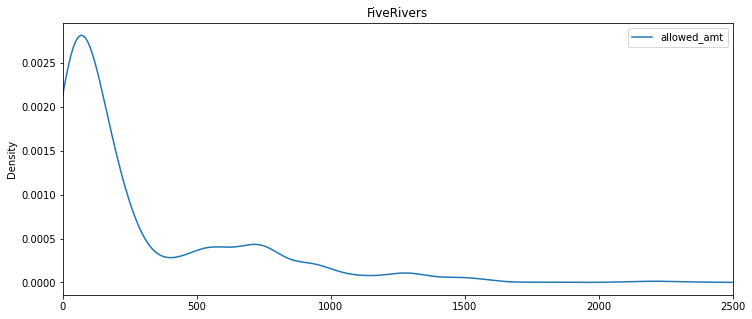

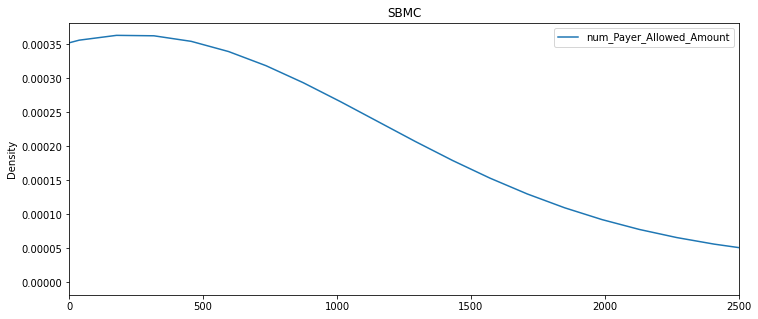

In [21]:
fiverivers[['allowed_amt']].plot.kde(xlim=(0,2500),figsize=(12,5), title='FiveRivers')
df[['num_Payer_Allowed_Amount']].plot.kde(xlim=(0,2500),figsize=(12,5), title = 'SBMC')

---

---

---

## Submitting Your Work

In order to submit your work, you'll need to use the `git` command line program to **add** your homework file (this file) to your local repository, **commit** your changes to your local repository, and then **push** those changes up to github.com.  From there, I'll be able to **pull** the changes down and do my grading.  I'll provide some feedback, **commit** and **push** my comments back to you.  The first line of code below will **pull** down my comments into your local folders.

To run through everything one last time and submit your work:
1. Use the `Kernel` -> `Restart Kernel and Run All Cells` menu option to run everything from top to bottom and stop here.
2. Save this note with Ctrl-S (or Cmd-S)
2. Skip down to the last command cell (the one starting with `%%bash`) and run that cell.

If anything fails along the way with this submission part of the process, let me know.  I'll help you troubleshoort.

In [22]:
assert False, "DO NOT REMOVE THIS LINE"

AssertionError: DO NOT REMOVE THIS LINE

---

In [ ]:
%%bash
git pull
git add week13_assignment.ipynb
git commit -a -m "Submitting the week 13 assignment"
git push


---

If the message above says something like _Submitting the week 10 review exercises_ or _Everything is up to date_, then your work was submitted correctly.